# Assumptions for the modeling guided by the EDA + intuitions
More trivial:
- temperature is inversed correlated with demand
- wind and solar intensity will bring down the GAS demand
- both the above effects are non linear
- should include day of the week and holidays in dataset

Less trivial: 
- wind and solar energy production increased over the years

Moreover, from the EDA I observe that the dataset is much lower dimensional than the number of features (10 features explain a lot of variance vs. 66 of the original dataset), so should probabily do a PCA step before other trainings. Also, PC1 is already a great indicator for demand.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.pipeline import Pipeline
import holidays as pyholidays


from utils import train_and_evaluate_model
from utils import plot_pred_vs_true, plot_errors
from utils import print_train_test_sizes

%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
sns.set_theme(style="whitegrid", context="notebook")

DATA_DIR = Path(".")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
print(train.shape, test.shape)

(3287, 68) (730, 67)


In [2]:
# First test things without holidays and added features
features = train.columns.difference(["id", "date", "demand"]).to_list()
print("Number of numeric/categorical candidate features:", len(features))
X = train[features]
y = train["demand"]
dates = train["date"]
print(f"X: {X.shape}, y: {y.shape}, dates: {dates.shape}")

Number of numeric/categorical candidate features: 65
X: (3287, 65), y: (3287,), dates: (3287,)


# Prepare the features + add holidays

In [3]:
# Ensure X is an independent copy to avoid SettingWithCopyWarning
X = X.copy()

# Standardize data before training
scaler = StandardScaler()
X.loc[:, features] = scaler.fit_transform(X[features])

# Add holidays + weekends as a feature
date_series = pd.to_datetime(train["date"])
years = range(date_series.dt.year.min(), date_series.dt.year.max() + 1)
uk_holidays = pyholidays.UnitedKingdom(years=years)

is_holiday = date_series.dt.date.isin(set(uk_holidays)).astype(int)
day_of_week = date_series.dt.dayofweek
is_weekend = day_of_week.isin([5, 6]).astype(int)

X["is_holiday"] = np.maximum(is_holiday, is_weekend).astype(int)

# Test different models

In [4]:
models = {
    "Linear Regression": LinearRegression(),
    "Linear Regression (log y)": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Spline Linear Regression": Pipeline(
        [
            (
                "spline",
                SplineTransformer(
                    n_knots=3, degree=2, extrapolation="linear", include_bias=False
                ),
            ),
            ("lin", LinearRegression()),
        ]
    ),
    "Spline + Ridge": Pipeline(
        [
            (
                "spline",
                SplineTransformer(
                    n_knots=3, degree=2, extrapolation="linear", include_bias=False
                ),
            ),
            ("ridge", Ridge(alpha=1.0)),
        ]
    ),
}
n_split = 5
training_years = 10

results = {}
for name, est in models.items():
    print(f"=== Training and evaluating {name} ===")
    if "log y" in name:
        # Use log1p/expm1 to avoid -inf for zeros
        results[name] = train_and_evaluate_model(
            model=est,
            X=X,
            y=y,
            date=dates,
            n_splits=n_split,
            training_years=training_years,
            pca_warmup=False,
            target_transform=np.log1p,
        )
    elif "Spline" in name:
        # Avoid applying PCA before spline expansion
        results[name] = train_and_evaluate_model(
            model=est,
            X=X,
            y=y,
            date=dates,
            n_splits=n_split,
            training_years=training_years,
            pca_warmup=False,
            target_transform=None,
        )
    else:
        results[name] = train_and_evaluate_model(
            model=est,
            X=X,
            y=y,
            date=dates,
            n_splits=n_split,
            training_years=training_years,
            pca_warmup=True,
            target_transform=None,
        )

print_train_test_sizes(results)

=== Training and evaluating Linear Regression ===
=== Training and evaluating Linear Regression (log y) ===
=== Training and evaluating Ridge Regression ===
=== Training and evaluating Spline Linear Regression ===
=== Training and evaluating Spline + Ridge ===
=== Linear Regression ===
Fold 1: Train points = 1462, Test points = 365, Ratio = 24.97%
	Training dates: 2009-01-01 to 2013-01-01, Testing dates: 2013-01-02 to 2014-01-01
Fold 2: Train points = 1827, Test points = 365, Ratio = 19.98%
	Training dates: 2009-01-01 to 2014-01-01, Testing dates: 2014-01-02 to 2015-01-01
Fold 3: Train points = 2192, Test points = 365, Ratio = 16.65%
	Training dates: 2009-01-01 to 2015-01-01, Testing dates: 2015-01-02 to 2016-01-01
Fold 4: Train points = 2557, Test points = 365, Ratio = 14.27%
	Training dates: 2009-01-01 to 2016-01-01, Testing dates: 2016-01-02 to 2016-12-31
Fold 5: Train points = 2922, Test points = 365, Ratio = 12.49%
	Training dates: 2009-01-01 to 2016-12-31, Testing dates: 2017-01-

# Visualise the resuls

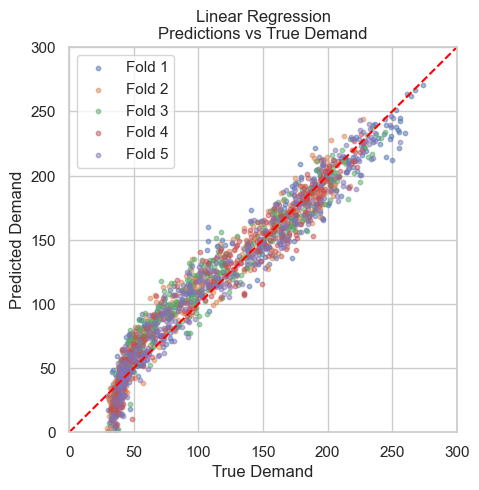

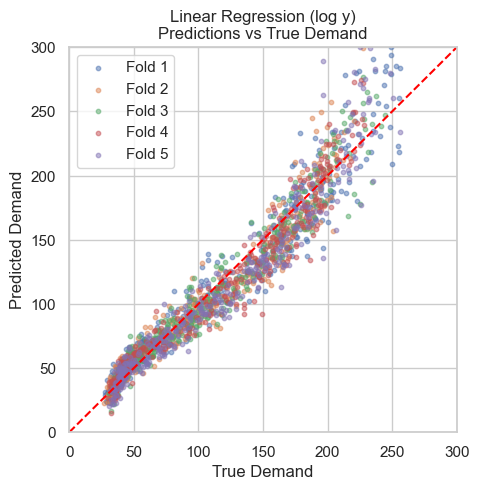

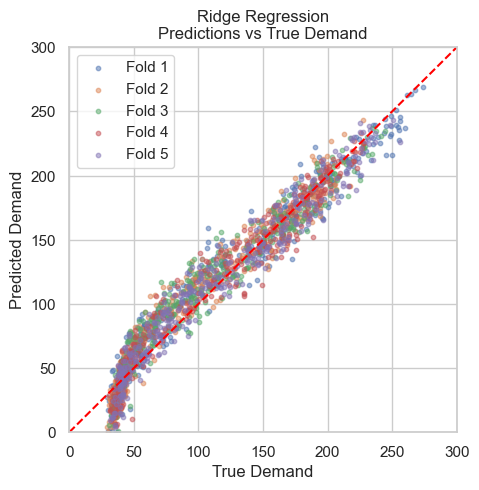

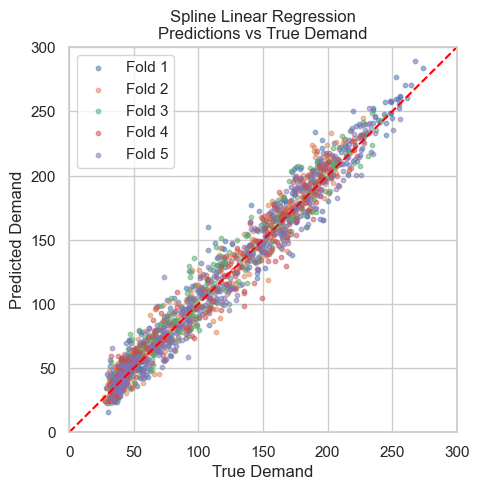

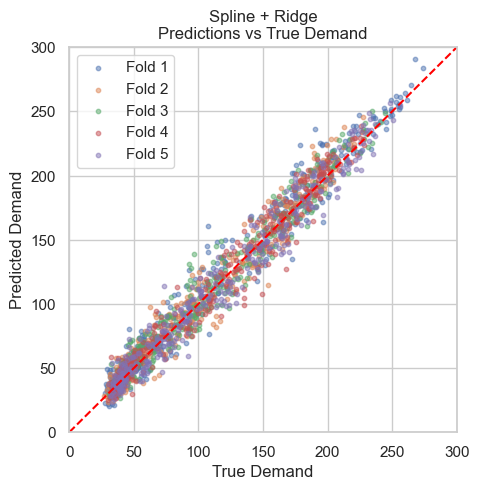

In [5]:
for name, res in results.items():
    plot_pred_vs_true(res["test"], title=f"{name}\nPredictions vs True Demand")

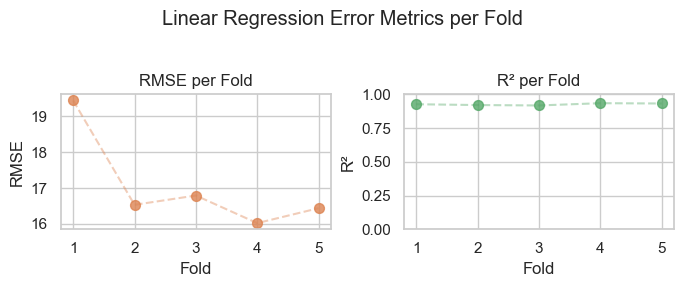

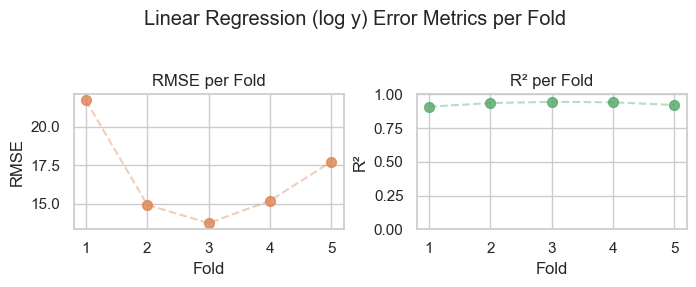

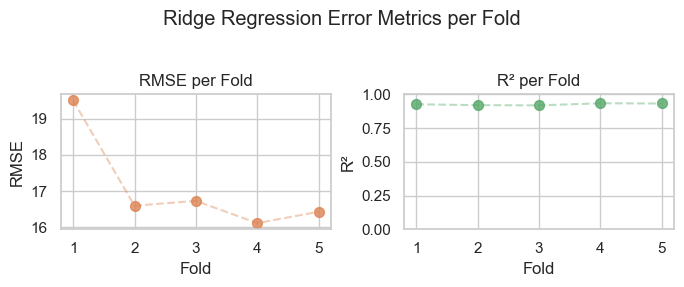

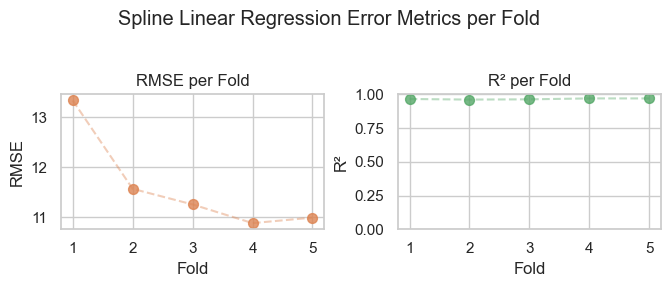

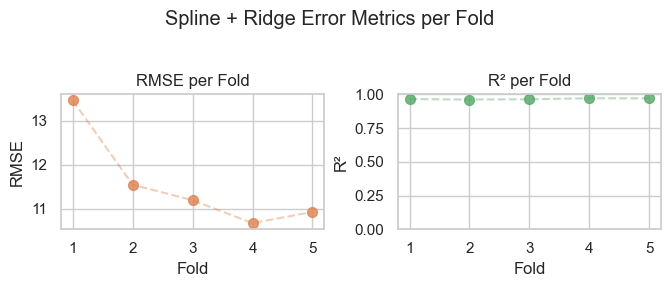

In [6]:
for name, res in results.items():
    plot_errors(res["metrics"], title=f"{name} Error Metrics per Fold")

In [7]:
# Get a table summarizing the results for each model
summary_rows = []
for name, res in results.items():
    metrics = res["metrics"]
    last_fold_metrics = {k: v[-1] for k, v in metrics.items()}
    row = {"Model": name}
    row.update(last_fold_metrics)
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
summary_df

,Model,rmse,r2
0,Linear Regression,16.438997,0.932096
1,Linear Regression (log y),17.740331,0.920920
2,Ridge Regression,16.430254,0.932169
3,Spline Linear Regression,10.992033,0.969640
4,Spline + Ridge,10.926037,0.970004


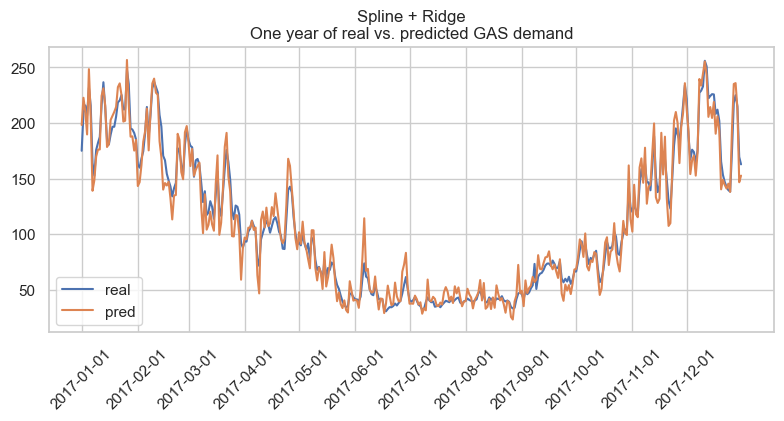

In [8]:
# Choose the best model and plot the last fold prediction vs. real demand over time
best_model_name = summary_df["Model"][summary_df["rmse"]==summary_df["rmse"].min()].values[0]

# For the best model make the plot of the last fold
y_real = results[best_model_name]["test"]["y"][-1]
y_pred = results[best_model_name]["test"]["y_pred"][-1]
dates = results[best_model_name]["test"]["date"][-1]

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(dates, y_real, label = "real")
ax.plot(dates, y_pred, label = "pred")

dates = pd.to_datetime(dates)
unique_months = dates.dt.to_period('M').unique()
xticks = []
for m in unique_months:
	first_date = dates[dates.dt.to_period('M') == m].iloc[0].strftime('%Y-%m-%d')
	xticks.append(first_date)
plt.xticks(xticks, xticks, rotation=45)
plt.tight_layout()

ax.set_title(f"{best_model_name}\nOne year of real vs. predicted GAS demand")
ax.legend()
plt.show()

# Train a model on all the data and find the demand for the test set

In [9]:
# Prepare the predictions for submission using the best model
final_model = models[best_model_name]

# I want to concatenate train and test and standardize them together then I will train the model only on the test set
all_data = pd.concat([train, test], ignore_index=True)
all_features = all_data.columns.difference(["id", "date", "demand"]).to_list()
X_all = all_data[all_features].copy()
X_all.loc[:, all_features] = scaler.fit_transform(X_all[all_features])

# Add holidays + weekends as a feature
date_series = pd.to_datetime(all_data["date"])
years = range(date_series.dt.year.min(), date_series.dt.year.max() + 1)
uk_holidays = pyholidays.UnitedKingdom(years=years)
is_holiday = date_series.dt.date.isin(set(uk_holidays)).astype(int)
day_of_week = date_series.dt.dayofweek
is_weekend = day_of_week.isin([5, 6]).astype(int)
X_all["is_holiday"] = np.maximum(is_holiday, is_weekend).astype(int)

# Train model on the entire training set
X_train = X_all.iloc[:len(train)]
y_train = train["demand"].values
assert len(X_train) == len(y_train), "Mismatch in training data sizes"
X_test = X_all.iloc[len(train):]
assert len(X_test) == len(test), "Mismatch in test data sizes"

# Fit the final model and make predictions
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)
y_train_pred = final_model.predict(X_train)

# Make a dataframe with the predictions
predictions_train = pd.DataFrame({
    "id": train["id"],
    "date": pd.to_datetime(train["date"]),
    "demand_real": y_train,
    "demand_pred": y_train_pred
})
predictions_test = pd.DataFrame({
    "id": test["id"],
    "date": pd.to_datetime(test["date"]),
    "demand_pred": y_test_pred
})


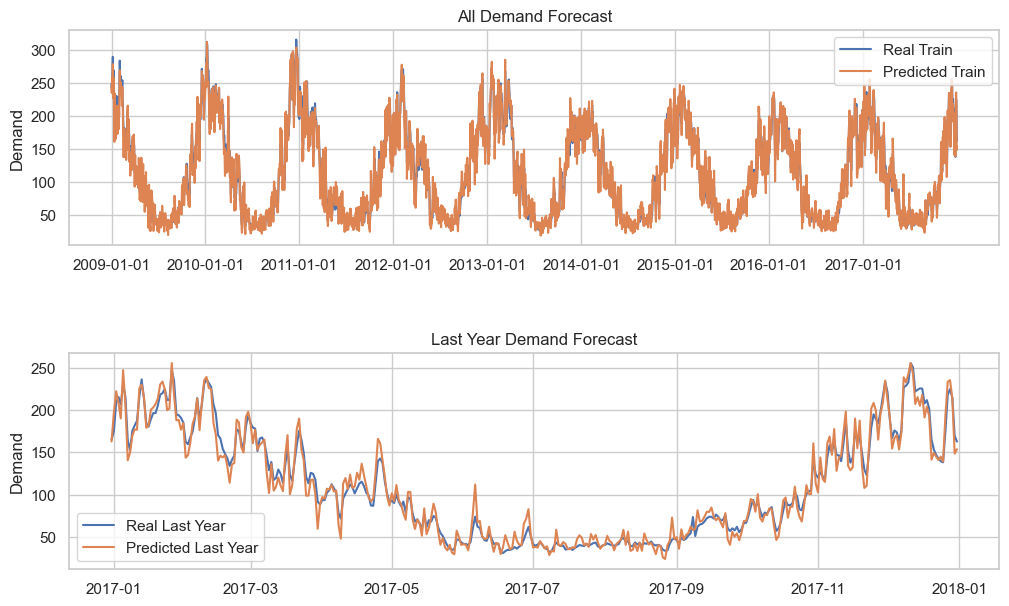

In [10]:
fig = plt.figure(figsize=(12,7))
grid = plt.GridSpec(nrows=2, ncols=1, wspace=0.4, hspace=0.5)

ax = fig.add_subplot(grid[0, 0])
ax.plot(predictions_train["date"], predictions_train["demand_real"], label="Real Train")
ax.plot(predictions_train["date"], predictions_train["demand_pred"], label="Predicted Train")

years = predictions_train["date"].dt.to_period('Y').unique()
xticks = []
for y in years:
	first_date = predictions_train["date"][predictions_train["date"].dt.to_period('Y') == y].iloc[0].strftime('%Y-%m-%d')
	xticks.append(first_date)
ax.set_xticks(xticks, xticks, rotation=0)

ax.set_ylabel("Demand")
ax.legend()
ax.set_title("All Demand Forecast")

ax = fig.add_subplot(grid[1, 0])
# select the previous year (offset by one year from the last date)
last_year_mask = (predictions_train["date"] >= (predictions_train["date"].max() - pd.DateOffset(years=1)))
pred_last_year = predictions_train[last_year_mask]
ax.plot(pred_last_year["date"], pred_last_year["demand_real"], label="Real Last Year")
ax.plot(pred_last_year["date"], pred_last_year["demand_pred"], label="Predicted Last Year")
ax.set_ylabel("Demand")
ax.legend()
ax.set_title("Last Year Demand Forecast")

plt.show()

# Save submission

In [11]:
# Save submission with only "id" and "demand"
submission = predictions_test[["id", "demand_pred"]].copy()
submission.rename(columns={"demand_pred": "demand"}, inplace=True)
submission.to_csv("submission.csv", index=False)